# 준비

In [1]:
import os
from glob import glob
import warnings
warnings.filterwarnings(action='ignore')

import pandas as pd
import numpy as np

from PIL import Image
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import losses, models, layers, optimizers, callbacks, utils, metrics
from tensorflow.keras.applications import EfficientNetB1

tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 데이터

100  images to be resized.


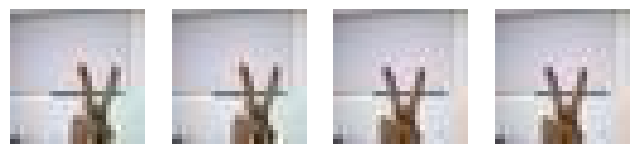

100  images resized.
가위 이미지 resize 완료!


In [10]:
# 데이터 크기 맞추기

def resize_images(img_path):
    images=glob(img_path + "/*.jpg")  
    
    print(len(images), " images to be resized.")

    # 파일마다 모두 28x28 사이즈로 바꾸어 저장합니다.
    target_size=(28,28)
    
    plt.figure(figsize=(8,3))
    for idx, img in enumerate(images,1):
        if idx<5:
            plt.subplot(1,4,idx)
            plt.imshow(plt.imread(img))
            plt.axis("off")
        old_img=Image.open(img)
        new_img=old_img.resize(target_size,Image.ANTIALIAS)
        new_img.save(img, "JPEG")
    plt.show()
    
    print(len(images), " images resized.")
    
image_dir_path = "../data/train/scissors/"
resize_images(image_dir_path)

print("가위 이미지 resize 완료!")

100  images to be resized.


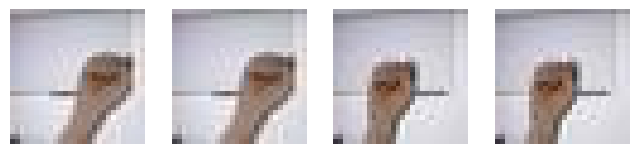

100  images resized.
100  images to be resized.


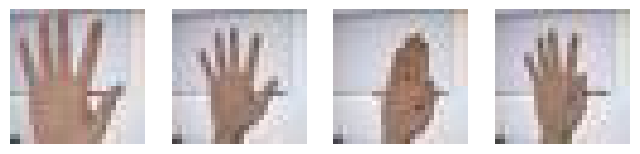

100  images resized.
100  images to be resized.


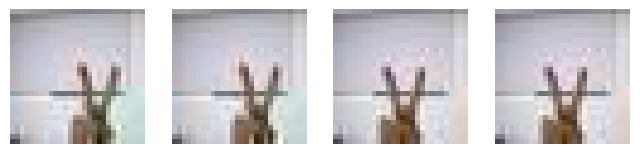

100  images resized.
110  images to be resized.


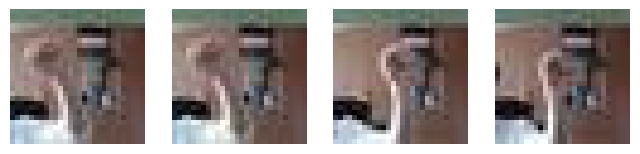

110  images resized.
110  images to be resized.


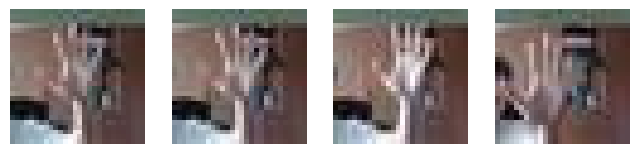

110  images resized.
110  images to be resized.


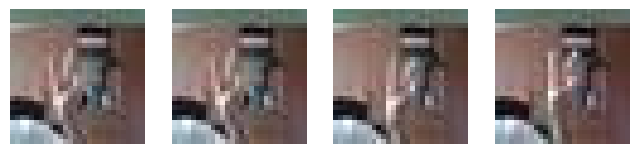

110  images resized.
100  images to be resized.


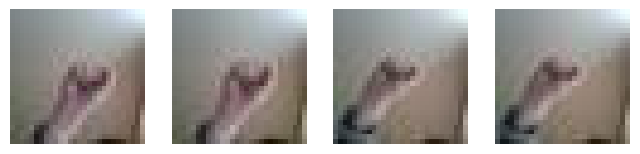

100  images resized.
100  images to be resized.


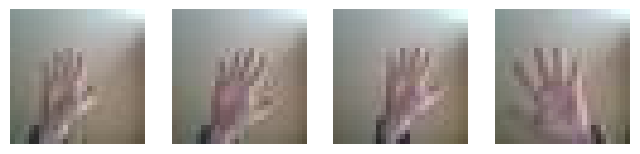

100  images resized.
100  images to be resized.


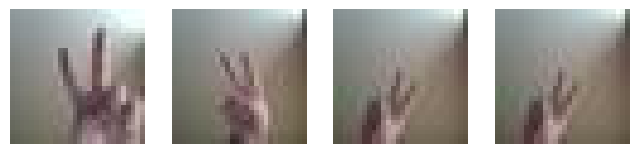

100  images resized.
100  images to be resized.


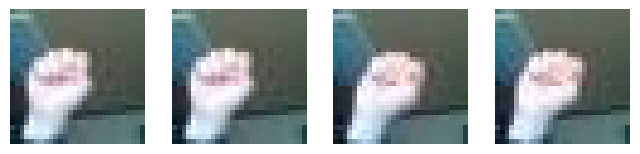

100  images resized.
100  images to be resized.


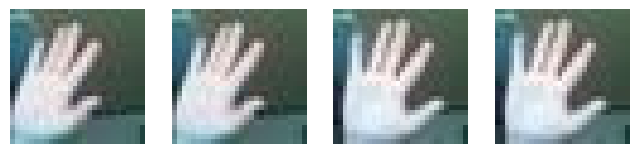

100  images resized.
100  images to be resized.


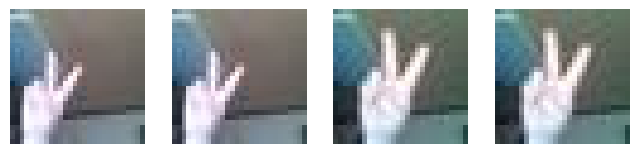

100  images resized.


In [12]:
# 3명의 친구들이 준 데이터로 학습, # 내가 만든데이터로 Test
for i in ["train","train2","train3","test"]:
    for j in ["rock","paper","scissors"]:
        image_dir_path = f"../data/{i}/{j}/"
        resize_images(image_dir_path)

In [13]:
# 3명의 가위/바위/보 데이터에서 100개씩만 가져와서 하나의 데이터로 합침

train_rock = glob("../data/train/rock/*")[:100]+glob("../data/train2/rock/*")[:100]+glob("../data/train3/rock/*")[:100]
train_paper = glob("../data/train/paper/*")[:100]+glob("../data/train2/paper/*")[:100]+glob("../data/train3/paper/*")[:100]
train_scissors = glob("../data/train/scissors/*")[:100]+glob("../data/train2/scissors/*")[:100]+glob("../data/train3/scissors/*")[:100]

# image_path, label 형태의 데이터 셋
train_all = train_rock+train_paper+train_scissors
train_target = ["rock"]*300+["paper"]*300+["scissors"]*300

print(len(train_rock),len(train_paper),len(train_scissors), len(train_all), len(train_target))

300 300 300 900 900


In [24]:
test_rock = glob("../data/test/rock/*")
test_paper = glob("../data/train/paper/*")
test_scissors = glob("../data/train/scissors/*")

test_all = test_rock+test_paper+test_scissors
test_target = ["rock"]*100+["paper"]*100+["scissors"]*100

print(len(test_rock),len(test_paper),len(test_scissors))

100 100 100


In [14]:
train_df = pd.DataFrame(columns=["path","target"])
train_df["path"]=train_all
train_df["target"]=train_target

In [25]:
test_df = pd.DataFrame(columns=["path","target"])
test_df["path"]=test_all
test_df["target"]=test_target

In [26]:
train_df,test_df

(                               path    target
 0          ../data/train/rock\0.jpg      rock
 1          ../data/train/rock\1.jpg      rock
 2         ../data/train/rock\10.jpg      rock
 3         ../data/train/rock\11.jpg      rock
 4         ../data/train/rock\12.jpg      rock
 ..                              ...       ...
 895  ../data/train3/scissors\95.jpg  scissors
 896  ../data/train3/scissors\96.jpg  scissors
 897  ../data/train3/scissors\97.jpg  scissors
 898  ../data/train3/scissors\98.jpg  scissors
 899  ../data/train3/scissors\99.jpg  scissors
 
 [900 rows x 2 columns],
                               path    target
 0          ../data/test/rock\0.jpg      rock
 1          ../data/test/rock\1.jpg      rock
 2         ../data/test/rock\10.jpg      rock
 3         ../data/test/rock\11.jpg      rock
 4         ../data/test/rock\12.jpg      rock
 ..                             ...       ...
 295  ../data/train/scissors\95.jpg  scissors
 296  ../data/train/scissors\96.jpg  scis

# 모델

In [16]:
# 모델링, 모델은 tensorflow 라이브러리에서 제공하는 데이터
def build_eff_model():
    x = layers.Input(shape=(32, 32, 3)) 
    y = EfficientNetB1(input_shape=(32,32,3), include_top=False, weights='imagenet')(x)
    y = layers.GlobalAveragePooling2D(name="avg_pool")(y)
    y = layers.BatchNormalization()(y)
    y = layers.Dense(32,activation=tf.keras.layers.LeakyReLU(),name="Dense_last")(y)
    y = layers.BatchNormalization()(y)
    y = layers.Dense(3, activation="softmax", name="Pred")(y)
    model = models.Model(x, y, name="EfficientNet_b1")
    optimizer = optimizers.Adam(learning_rate=0.0002)
    loss = losses.SparseCategoricalCrossentropy()
    model.compile(optimizer=optimizer, loss=loss, metrics=["acc"])
    return model

# 증강
simple_aug = tf.keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
        layers.RandomBrightness(0.2),
        layers.RandomContrast(0.2)
    ]
)

# 이미지, 라벨 받기
def process_path(file_path, target):
    
    def get_label(target):
        one_hot = target == class_names  # True / False
        return tf.argmax(one_hot)

    label = get_label(target)
    img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [32, 32])
    img = img / 255  
    return img, label

# Dataset performance
def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

In [17]:
from IPython.display import clear_output
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt

# 학습 실시간 시각화
class PlotLearning(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []   
    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]     
        metrics = [x for x in logs if 'val' not in x]
        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        clear_output(wait=True)
        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric)      
            axs[i].legend()
        plt.tight_layout()
        plt.show()

# 훈련

In [36]:
# DS
list_ds = tf.data.Dataset.from_tensor_slices( (train_df["path"].values, train_df["target"].values) )
list_ds = list_ds.shuffle(len(list_ds), reshuffle_each_iteration=False)
class_names = np.array( train_df["target"].unique() )

test_ds = tf.data.Dataset.from_tensor_slices( (test_df["path"].values, test_df["target"].values) )

# DS split (15%)
val_size = int(len(list_ds)*0.15)
train_ = list_ds.skip(val_size)
valid_ = list_ds.take(val_size)
NUM_TRAIN = tf.data.experimental.cardinality(train_).numpy()
NUM_VALID = tf.data.experimental.cardinality(valid_).numpy()

In [37]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
batch_size = 16

# 전처리
train_ds = train_.map(process_path, num_parallel_calls=AUTOTUNE)
valid_ds = valid_.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)
# 증강
train_ds = train_ds.map(lambda x, y: (simple_aug(x), y), num_parallel_calls=AUTOTUNE)
# 성능향상
train_ds = configure_for_performance(train_ds) 
valid_ds = configure_for_performance(valid_ds)

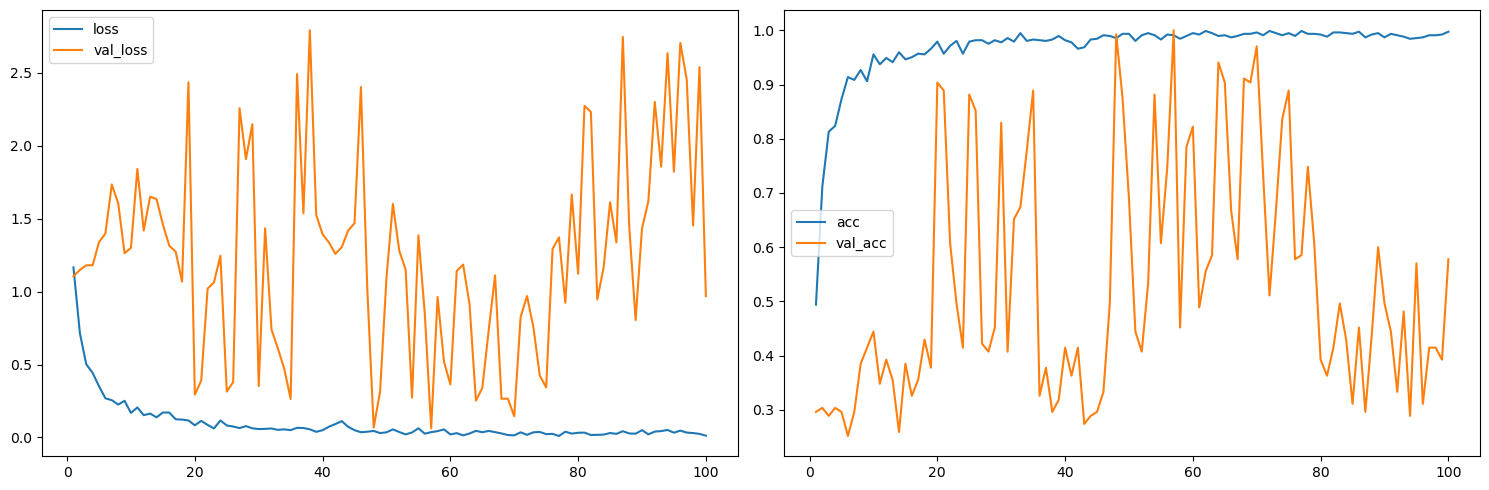

48/48 [==============================] - 4s 76ms/step - loss: 0.0120 - acc: 0.9974 - val_loss: 0.9700 - val_acc: 0.5778


In [21]:
# 모델
model = build_eff_model()
# callback
ckp = callbacks.ModelCheckpoint(f"RPS.h5", save_best_only=True,  monitor="val_acc")
# 학습
history = model.fit(train_ds, epochs=100, validation_data=valid_ds, callbacks=[PlotLearning(),ckp])

In [22]:
model = model.load_weights("RPS.h5")

In [38]:
result = model.predict(test_ds)

300/300 [==============================] - 8s 18ms/step


In [43]:
test_df["result"] = np.argmax(result,-1)
def target_label(target):
    target_dict = {"rock":0,"paper":1,"scissors":2}
    return target_dict[target]
test_df["target_labeled"] = test_df["target"].apply(target_label)

test_df

,path,target,result,target_labeled
0,../data/test/rock\0.jpg,rock,0,0
1,../data/test/rock\1.jpg,rock,0,0
2,../data/test/rock\10.jpg,rock,0,0
3,../data/test/rock\11.jpg,rock,0,0
4,../data/test/rock\12.jpg,rock,0,0
...,...,...,...,...
295,../data/train/scissors\95.jpg,scissors,2,2
296,../data/train/scissors\96.jpg,scissors,2,2
297,../data/train/scissors\97.jpg,scissors,2,2
298,../data/train/scissors\98.jpg,scissors,2,2


In [45]:
from sklearn.metrics import accuracy_score

In [47]:
accuracy_score(test_df["target_labeled"], test_df["result"])

0.9966666666666667

In [56]:
test_df[test_df["result"]!=test_df["target_labeled"]]

,path,target,result,target_labeled
253,../data/train/scissors\57.jpg,scissors,0,2


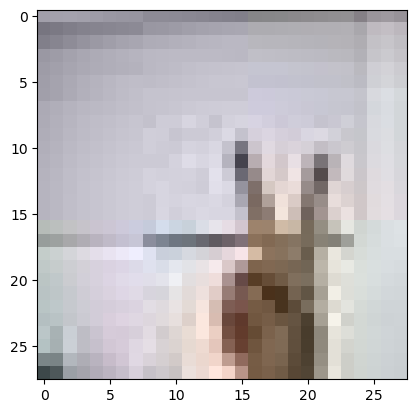

In [55]:
# 틀린 유일한 데이터
plt.imshow(plt.imread("../data/train/scissors/57.jpg"))